# Instructions -

The goal of this task is to explore the Yelp data set to get a sense about what the data look like and their characteristics. You can think about the goal as being to answer questions such as:

What are the major topics in the reviews? Are they different in the positive and negative reviews? Are they different for different cuisines?

What does the distribution of the number of reviews over other variables (e.g., cuisine, location) look like?

What does the distribution of ratings look like?





# Part 1:
For Yelp's Data Exploration we will use LDA topic model to extract topics from  the review text (positive and negative reviews) seperately and then we will try to visualize the topics to understand what people have talked about in these reviews. We will Use wordcloud to visualize topic clusters.

In [21]:
import matplotlib.pyplot as plt 
import nltk
import pandas as pd
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
import gensim
from gensim.utils import lemmatize, simple_preprocess
import gensim.corpora as corpora
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import spacy, logging, warnings

In [22]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # TABLEAU COLORS



# 1.1  Pre-Processing Yelp's dataset
- Reading Yelp's dataset (Please Note - Create a folder name "data" and save all Yelp dataset files there) 

In [23]:
topic_size = 10
yelp_business = pd.read_json("./data/yelp_academic_dataset_business.json", lines=True)
yelp_checkin = pd.read_json("./data/yelp_academic_dataset_checkin.json", lines=True)
yelp_reviews = pd.read_json("./data/yelp_academic_dataset_review.json", lines=True)
yelp_tip = pd.read_json("./data/yelp_academic_dataset_tip.json", lines=True)
yelp_user = pd.read_json("./data/yelp_academic_dataset_user.json", lines=True)



In [24]:
yelp_reviews.shape

(1125458, 8)

# 1.2  Distribution Plot of stars in review
- Let's first plot the distribution of stars in review

In [25]:
(yelp_reviews.groupby(['stars'])['business_id'].count()/yelp_reviews['business_id'].count()*100)

stars
1     9.842393
2     9.128461
3    14.550610
4    30.400335
5    36.078201
Name: business_id, dtype: float64

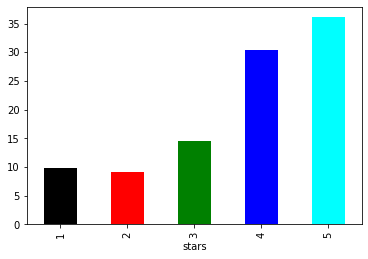

In [26]:
(yelp_reviews.groupby(['stars'])['business_id'].count()/yelp_reviews['business_id'].count()*100).plot.bar(color=['black', 'red', 'green', 'blue', 'cyan'])
plt.show()

## 1.3 Topic Mining of restaurant reviews

In [27]:
yelp_reviews_sample= yelp_reviews.sample(n=10000, random_state = 2019)

In [28]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'use', 'not', 'would', 'say', 'could', '_', 
                   'be', 'know', 'go', 'get', 'do', 'done', 'many', 'some', 
                    'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make',
                   'want', 'seem', 'run', 'need', 'even', 'right', 'even', 'also', 
                   'may', 'take', 'come'])



In [29]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # here we are removing new line characters
        sent = re.sub("\'", "", sent)  # here we are removing single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)  # deacc=True this will remove accent marks
        yield(sent)
        
             
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out



In [30]:
reviews_list = yelp_reviews_sample.text.tolist()
data_reviews = list(sent_to_words(reviews_list))
bigram = gensim.models.Phrases(data_reviews, min_count=3) #removes all words <3 letter counts
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_ready = process_words(data_reviews) 
# Create Dictionary
id2word = corpora.Dictionary(data_ready)
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [31]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
doc_topics = lda_model.get_document_topics(corpus)

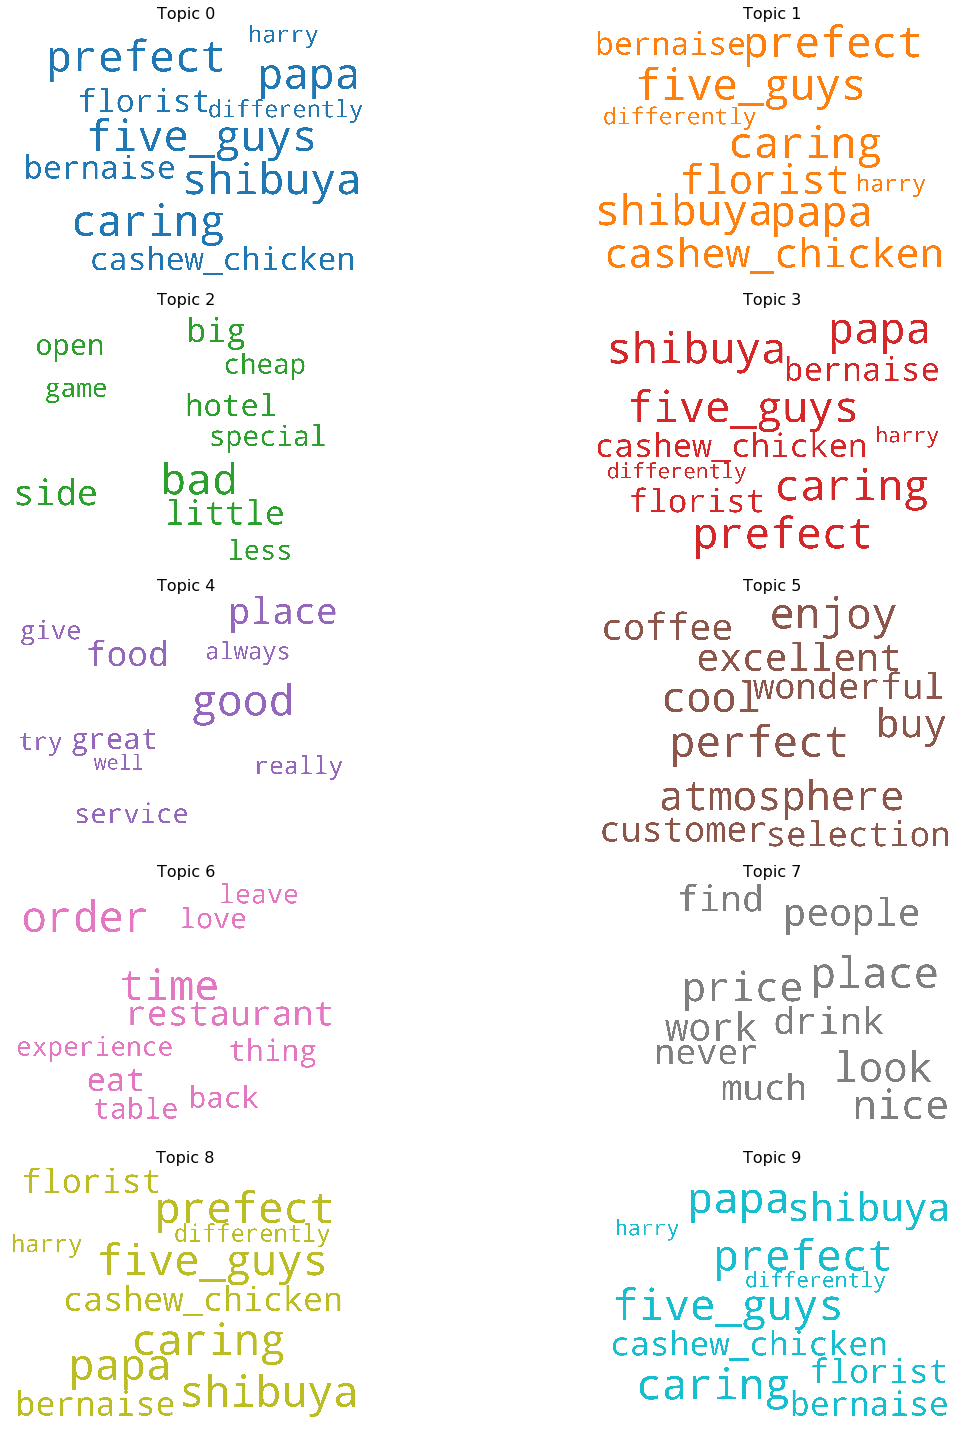

In [32]:

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Topic Mining of positive and negative reviews

In [33]:
yelp_positive_reviews = yelp_reviews[yelp_reviews['stars'] == 5]
yelp_positive_sample = yelp_positive_reviews.sample(n=10000, random_state = 2019)

yelp_negative_reviews = yelp_reviews[yelp_reviews['stars'] < 3]
yelp_negative_sample = yelp_negative_reviews.sample(n=10000, random_state = 2019)


In [34]:
#positive
yelp_reviews_list = yelp_positive_sample.text.tolist()
yelp_data_reviews = list(sent_to_words(reviews_list))
bigram = gensim.models.Phrases(yelp_data_reviews, min_count=3) #removes all words <3 letter counts
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_ready = process_words(yelp_data_reviews) 
# Create Dictionary
id2word_positive = corpora.Dictionary(data_ready)
# Create Corpus: Term Document Frequency
positive_corpus = [id2word_positive.doc2bow(text) for text in data_ready]

#negative
yelp_reviews_list = yelp_negative_sample.text.tolist()
yelp_data_reviews = list(sent_to_words(yelp_reviews_list))
bigram = gensim.models.Phrases(yelp_data_reviews, min_count=3) #removes all words <3 letter counts
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_ready = process_words(yelp_data_reviews) 
# Create Dictionary
id2word_negative = corpora.Dictionary(data_ready)
# Create Corpus: Term Document Frequency
negative_corpus = [id2word_negative.doc2bow(text) for text in data_ready]

In [35]:
positive_lda_model = gensim.models.ldamodel.LdaModel(corpus=positive_corpus,
                                           id2word=id2word_positive,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
positive_doc_topics = positive_lda_model.get_document_topics(positive_corpus)

negative_lda_model = gensim.models.ldamodel.LdaModel(corpus=negative_corpus,
                                           id2word=id2word_negative,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
negative_doc_topics = negative_lda_model.get_document_topics(negative_corpus)

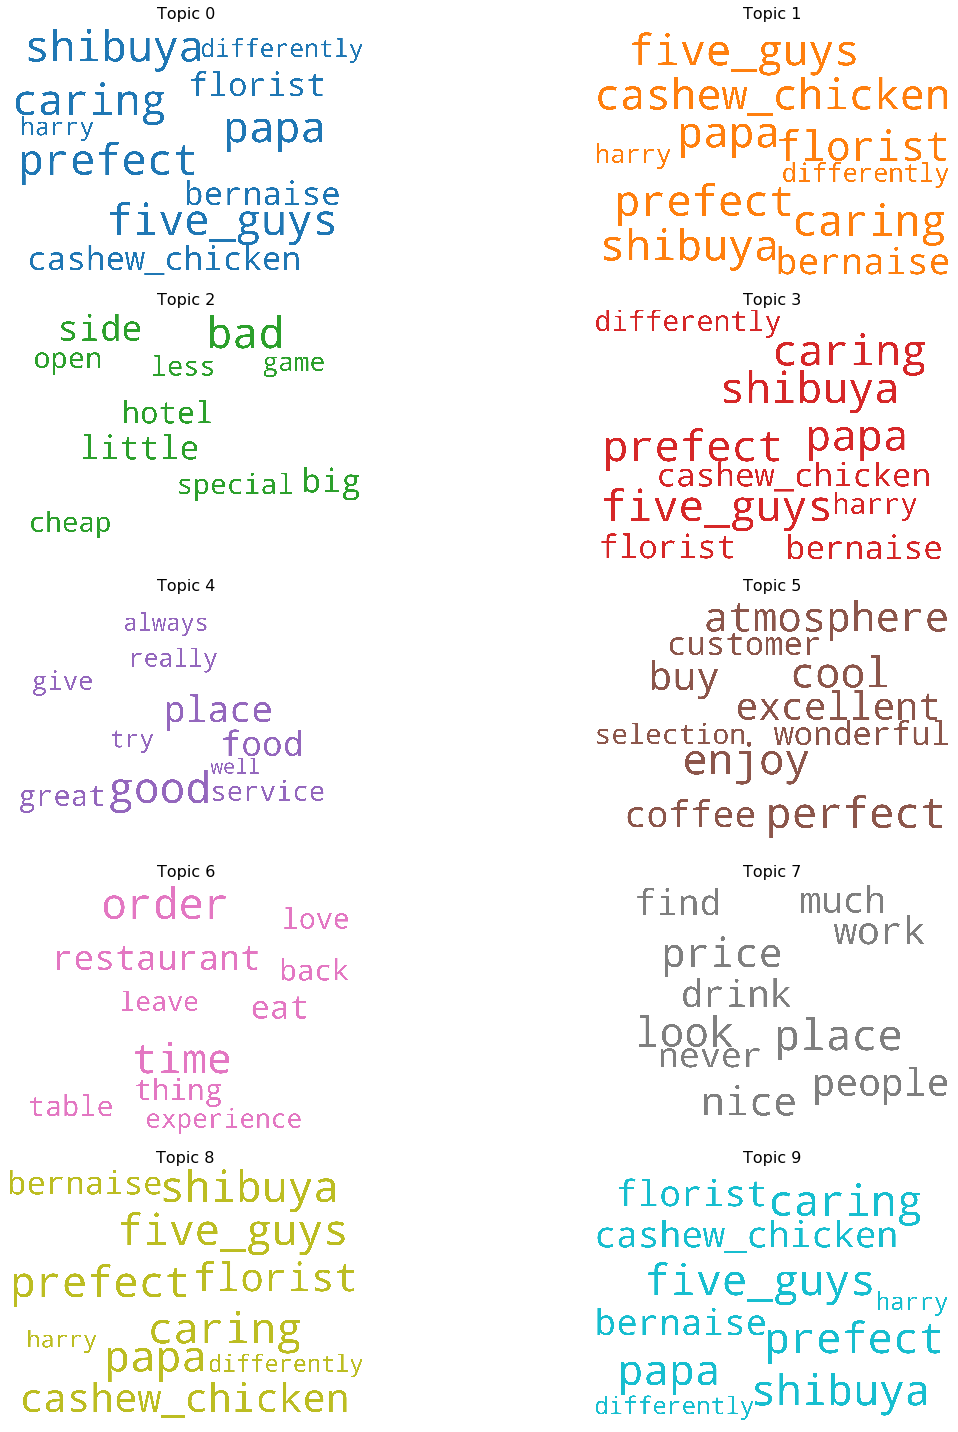

In [36]:

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = positive_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

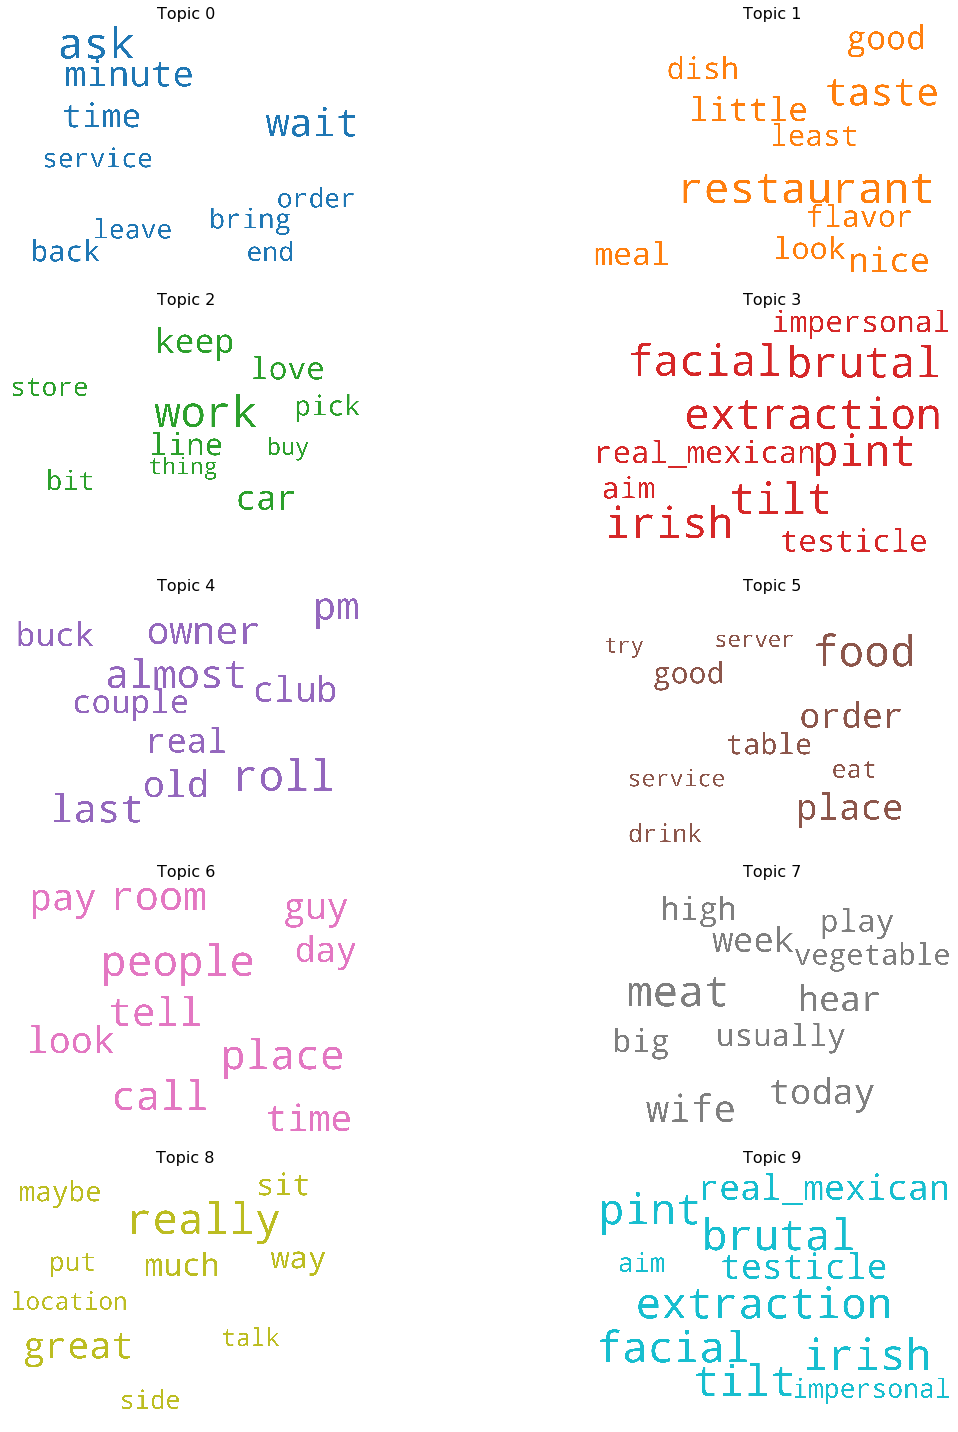

In [37]:

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = negative_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [38]:
topics[i]

(9,
 [('brutal', 5.0422674e-05),
  ('facial', 5.0422583e-05),
  ('extraction', 5.0410265e-05),
  ('tilt', 5.0406055e-05),
  ('irish', 5.0406048e-05),
  ('pint', 5.0406034e-05),
  ('real_mexican', 5.040584e-05),
  ('testicle', 5.0405433e-05),
  ('impersonal', 5.040471e-05),
  ('aim', 5.0404426e-05)])

# Conclusion
Overall after looking at the results that are displayed in word cloud visualization we can say that LDA topic have provided us very good results. Taking glance at positive topics we can say that we were able to compile the results based on positive feelings with keywords such as “love”, “wonderful”, “caring”, “great”. Whereas negative topics reveals mix of negative and mix expression with keywords such as “wait”, “old”, “brutal”, “impersonal” etc... These prominent words within the topics make intuitive sense, but some of the topics themselves are reasonable. For instance, positive reviews could include: Five Guys Burgers & Fries are so delicious.  The negative reviews could be something like: We had to wait in line for long time had to leave due to slow service of restaurant.


Moreover we can also say that LDA topic has done excellent job in creating word topic cluster for positive and negative reviews. If we look at word cloud topic we can say that topics 0, 1, 3, 4, 5, 7, 8, 9 are based of positive reviews and topics 2 and 6 are based on negative reviews.

